# NASA Lithium Battery RUL Prediction

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote
from sklearn.preprocessing import MinMaxScaler

## Import libraries for the model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Set path for saving model training results 
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'nasa_battery'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
len(name)

16739

## Converting TAG Name Format
* After checking all the Tag Names from the Nasa bearing dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use tag names related to the B0001, B0005, B0007

In [5]:
# Set the desired tag names
tags_1 = ['B0001_Capacity', 'B0001_Current_load', 'B0001_Current_measured', 'B0001_Temperature_measured', 'B0001_Voltage_load', 'B0001_Voltage_measured']
tags_5 = ['B0005_Capacity', 'B0005_Current_load', 'B0005_Current_measured', 'B0005_Temperature_measured', 'B0005_Voltage_load', 'B0005_Voltage_measured']
tags_7 = ['B0007_Capacity', 'B0007_Current_load', 'B0007_Current_measured', 'B0007_Temperature_measured', 'B0007_Voltage_load', 'B0007_Voltage_measured']

# Wrap each item in the list with single quotes and separate with commas
tags_1 = ",".join(f"'{tag}'" for tag in tags_1)
tags_5 = ",".join(f"'{tag}'" for tag in tags_5)
tags_7 = ",".join(f"'{tag}'" for tag in tags_7)

# Check the selected tag names
print(tags_1)
print(tags_5)
print(tags_7)

'B0001_Capacity','B0001_Current_load','B0001_Current_measured','B0001_Temperature_measured','B0001_Voltage_load','B0001_Voltage_measured'
'B0005_Capacity','B0005_Current_load','B0005_Current_measured','B0005_Temperature_measured','B0005_Voltage_load','B0005_Voltage_measured'
'B0007_Capacity','B0007_Current_load','B0007_Current_measured','B0007_Temperature_measured','B0007_Voltage_load','B0007_Voltage_measured'


## Loading NASA Lithium Battery Dataset

In [6]:
# Data loading parameter settings

# Set the tag table name
table = 'nasa_battery'
# Set the tag names
name_1 = quote(tags_1, safe=":/")
name_5 = quote(tags_5, safe=":/")
name_7 = quote(tags_7, safe=":/")
# Set the time format 
timeformat = quote('2006-01-02 15:04:05.000000')
# Set the data start time
start_time = quote('2010-07-21 15:00:00')
# Set the data end time
end_time = quote('2010-07-21 17:00:00')

In [7]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')
        
    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()
    
    df = df.drop(['TIME'], axis=1)
    
    return df    

In [8]:
# Load data
df_1 = data_load(table, name_1, start_time, end_time, timeformat)
df_5 = data_load(table, name_5, start_time, end_time, timeformat)
df_7 = data_load(table, name_7, start_time, end_time, timeformat)

df_1

NAME,B0001_Capacity,B0001_Current_load,B0001_Current_measured,B0001_Temperature_measured,B0001_Voltage_load,B0001_Voltage_measured
0,1.674305,0.0002,0.000252,6.212696,0.000,4.246711
1,1.674305,0.0002,-0.001411,6.234019,4.262,4.246764
2,1.674305,1.0000,-0.995093,6.250255,3.465,4.039277
3,1.674305,1.0000,-0.996731,6.302176,3.451,4.019506
4,1.674305,1.0000,-0.992845,6.361645,3.438,4.004763
...,...,...,...,...,...,...
485,1.674305,0.0004,-0.001760,9.662331,0.000,3.303251
486,1.674305,0.0002,-0.000756,9.390489,0.000,3.310303
487,1.674305,0.0002,-0.003318,9.137008,0.000,3.317351
488,1.674305,0.0002,-0.002291,8.972806,0.000,3.323387


## Data Preprocessing 1

* 1 MinMax Scaling

In [9]:
# Scaler Setup
scaler = MinMaxScaler()

# Apply Scaler
train_ = scaler.fit_transform(df_1.values)
valid_ = scaler.transform(df_5.values)
test_ = scaler.transform(df_7.values)

# Set DataFrames
train_scaled = pd.DataFrame(train_)
valid_scaled = pd.DataFrame(valid_)
test_scaled = pd.DataFrame(test_)

## Dataset & Loader Setup

In [10]:
class Battery_Dataset(Dataset):

    def __init__(self, df):
        self.freq_data = df
        
    def __len__(self):
        return len(self.freq_data)

    def __getitem__(self, index):

        input_time_data = self.freq_data.iloc[index,:]
        input_time_data = torch.Tensor(input_time_data).expand(1, input_time_data.shape[0]).reshape(1,-1)

        return input_time_data

In [11]:
# Set up datasets  
train_ = Battery_Dataset(train_scaled)
valid_ = Battery_Dataset(valid_scaled)
test_ = Battery_Dataset(test_scaled)

# Set up data loaders
train_dataloader = DataLoader(train_, batch_size=16, shuffle=False)
valid_dataloader = DataLoader(valid_, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_, batch_size=1, shuffle=False)

In [12]:
# Verify DataLoader application and check the shape of the input data
print(list(train_dataloader)[0].shape)

torch.Size([16, 1, 6])


## Health Index Extraction Model Configuration
* Using LSTM AE model.

In [13]:
# LSTM Autoencoder class definition
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, 2*hidden_dim)
        
        # Decoder LSTM
        self.decoder_fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)

    def forward(self, x):
        # Encoder part
        _, (h, _) = self.encoder_lstm(x)
        latent = self.encoder_fc(h[-1])
        
        # Decoder part
        hidden = self.decoder_fc(latent).unsqueeze(0).repeat(x.size(1), 1, 1).permute(1, 0, 2)
        output, _ = self.decoder_lstm(hidden)
        
        return output

In [14]:
# Model configuration parameters

# number of input data columns
# last number in print(list(train_dataloader)[0].shape)
input_dim = 6

# LSMT hidden state size
hidden_dim = 2

# layer size
num_layers = 2

# Learning rate 
learning_rate = 0.001

# Model configuration
model = LSTMAutoencoder(input_dim, hidden_dim, num_layers).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

LSTMAutoencoder(
  (encoder_lstm): LSTM(6, 2, num_layers=2, batch_first=True)
  (encoder_fc): Linear(in_features=2, out_features=4, bias=True)
  (decoder_fc): Linear(in_features=4, out_features=2, bias=True)
  (decoder_lstm): LSTM(2, 6, num_layers=2, batch_first=True)
)


## Health Index Extraction Model Training

* Save the model with the Best Loss based on the training data during training.

In [15]:
# Initialize loss
train_loss = []
# Initialize total step
total_step = len(train_dataloader)
# Set number of epochs
epoch_in = trange(100, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:
    model.to(device)
    model.train()
    running_loss = 0.0

    preds_ = []
    targets_ = []

    for batch_idx, train_data in enumerate(train_dataloader):

        inputs = train_data[0].to(device).float()

        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(inputs)
 
        # Calculate loss 
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')

    # Save the best model
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/Nasa_Battery_General_Health_Index.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.2841638816941169


c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 6])) that is different to the input size (torch.Size([1, 6, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Model saved

train loss: 0.2614850341793029
Model saved

train loss: 0.2375170112617554
Model saved

train loss: 0.21340577442559502
Model saved

train loss: 0.19111050295252952
Model saved

train loss: 0.1729699814071258
Model saved

train loss: 0.15876427359776013
Model saved

train loss: 0.14732417486788285
Model saved

train loss: 0.13787764876306485
Model saved

train loss: 0.12993612455264217
Model saved

train loss: 0.12316632083456014
Model saved

train loss: 0.11732890134957691
Model saved

train loss: 0.11224606773693568
Model saved

train loss: 0.10778242920006065
Model saved

train loss: 0.10383285989243819
Model saved

train loss: 0.10031441813372376
Model saved

train loss: 0.09716077720255112
Model saved

train loss: 0.09431827769491247
Model saved

train loss: 0.09174306332078368
Model saved

train loss: 0.08939896034106852
Model saved

train loss: 0.08725588141830377
Model saved

train loss: 0.08528860676432809
Model saved

train loss: 0.08347584355131396
Model saved



## Health Index Extraction

In [16]:
# Load the best Health Index Extraction model
model_ = torch.load(f'./result/Nasa_Battery_General_Health_Index.pt') 

In [17]:
# Extract validation data Health Index
Train_Health_Index = []
with torch.no_grad():
    
    for batch_idx, valid_data in enumerate(valid_dataloader):

        inputs_val = valid_data[0].to(device).float()

        outputs_val = model_(inputs_val)
        loss = criterion(outputs_val, inputs_val)
        
        Train_Health_Index.append(loss.item())

In [18]:
# Extract test data Health Index
Test_Health_Index = []
with torch.no_grad():
    model_.eval()
    for batch_idx, test_data in enumerate(test_dataloader):

        inputs_test = test_data[0].to(device).float()

        outputs_test = model_(inputs_test)
        loss = criterion(outputs_test, inputs_test)
        
        Test_Health_Index.append(loss.item())

## Data Preprocessing 2

* 1 MinMax Scaling

In [19]:
# Convert Train_Health_Index to a numpy array
Train_Health_Index = np.array(Train_Health_Index).reshape(-1, 1)
Test_Health_Index = np.array(Test_Health_Index).reshape(-1, 1)

# Set up MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMax Scaling
Train_Health_Index = scaler.fit_transform(Train_Health_Index)
Test_Health_Index = scaler.transform(Test_Health_Index)

# Set DataFrame
Train_Health_Index = Train_Health_Index
Train_Health_Index = pd.DataFrame(Train_Health_Index)

Test_Health_Index  = Test_Health_Index
Test_Health_Index = pd.DataFrame(Test_Health_Index)

## Dataset & Loader Setup 2

In [20]:
# Sliding Window Dataset Configuration
def time_slide_df(df, window_size, forecast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forecast_size+1):
        x = df_.iloc[idx:idx+window_size].values.reshape(window_size, df.shape[1])
        y = df_.iloc[idx+window_size:idx+window_size+forecast_size].values
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
# Window size: How many past data points will be used
# Forecast: How many future data points to forecast
window_size = 5
forecast_size= 1

# Set up datasets 
train_x, train_y = time_slide_df(Train_Health_Index, window_size, forecast_size)
test_x, test_y = time_slide_df(Test_Health_Index, window_size, forecast_size)

train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)

train_dataloader_ = DataLoader(train_ds, batch_size = 16, shuffle=False)
test_dataloader_ = DataLoader(test_ds,  batch_size = 1, shuffle=False)

## Health Index Prediction Model Configuration
* Using DLinear model.

In [22]:
## modeling
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - 0.3*moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forecast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size

        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forecast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forecast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forecast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forecast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:

            trend_output = self.Linear_Trend(trend_init)

            seasonal_output = self.Linear_Seasonal(seasonal_init)
            
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [23]:
# Model configuration parameters

# Learning rate
lr = 0.001

# Model configuration
model = LTSF_DLinear(
                    window_size=window_size,
                    forecast_size=forecast_size,
                    kernel_size=25,
                    individual=False,
                    feature_size=1
                    ).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Check the model architecture
print(model)

LTSF_DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Trend): Linear(in_features=5, out_features=1, bias=True)
  (Linear_Seasonal): Linear(in_features=5, out_features=1, bias=True)
)


## Health Index Prediction Model Training

* Save the model with the Best Loss based on the training data during training.

In [24]:
# Initialize loss
train_loss = []
# Initialize total step
total_step = len(train_dataloader_)
# Set number of epochs
epoch_in = trange(500, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:
    model.to(device)
    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_dataloader_):
        
        data = data.to(device).float()
        target = target.to(device).float()
        
        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(data)

        # Calculate loss
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')

    # Save the best model
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/Nasa_Battery_General_RUL.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/500 [00:00<?, ?it/s]


train loss: 0.11197337977312229
Model saved

train loss: 0.09532926145389123
Model saved

train loss: 0.08152982456333659
Model saved

train loss: 0.07024370444964409
Model saved

train loss: 0.06108229378695357
Model saved

train loss: 0.053664834816533384
Model saved

train loss: 0.04764753506471471
Model saved

train loss: 0.042737157920243955
Model saved

train loss: 0.0386943174635085
Model saved

train loss: 0.03532973995391296
Model saved

train loss: 0.032496920858185674
Model saved

train loss: 0.03008383954149821
Model saved

train loss: 0.028005263949061165
Model saved

train loss: 0.026196286099168
Model saved

train loss: 0.024607209912138377
Model saved

train loss: 0.023199658263550832
Model saved

train loss: 0.02194367951355744
Model saved

train loss: 0.020815624141973244
Model saved

train loss: 0.019796595268296593
Model saved

train loss: 0.01887131714586724
Model saved

train loss: 0.018027303809131652
Model saved

train loss: 0.01725424366703971
Model saved

tra

## Model Testing

In [25]:
# Load the best model
model_ = torch.load(f'./result/Nasa_Battery_General_RUL.pt')

In [26]:
# Initial settings 
output_test = []
target_test = []

with torch.no_grad():
    model_.eval()
    running_loss_t = 0.0
    
    for batch_idx, (data, target) in enumerate(test_dataloader_):
        
        data_t = data.to(device).float()
        target_t = target.to(device).float()

        outputs_t = model_(data_t)
        
        output_test.append(outputs_t)
        target_test.append(target_t)
        
# Combine tensors into one
combined_tensor_target = torch.cat(target_test, dim=0)
combined_tensor_pred = torch.cat(output_test, dim=0)

# Use only the last value of the window
last_values_target = combined_tensor_target[:,:1].cpu().numpy().reshape(-1, 1)
last_values_pred = combined_tensor_pred[:,:1].cpu().numpy().reshape(-1, 1)

## Model Performance Evaluation

In [27]:
# Calculate MSE
mse = mean_squared_error(last_values_target, last_values_pred)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(last_values_target, last_values_pred)
print("R² Score:", r2)

Mean Squared Error: 2.7359241e-05
R² Score: 0.9856471830848987


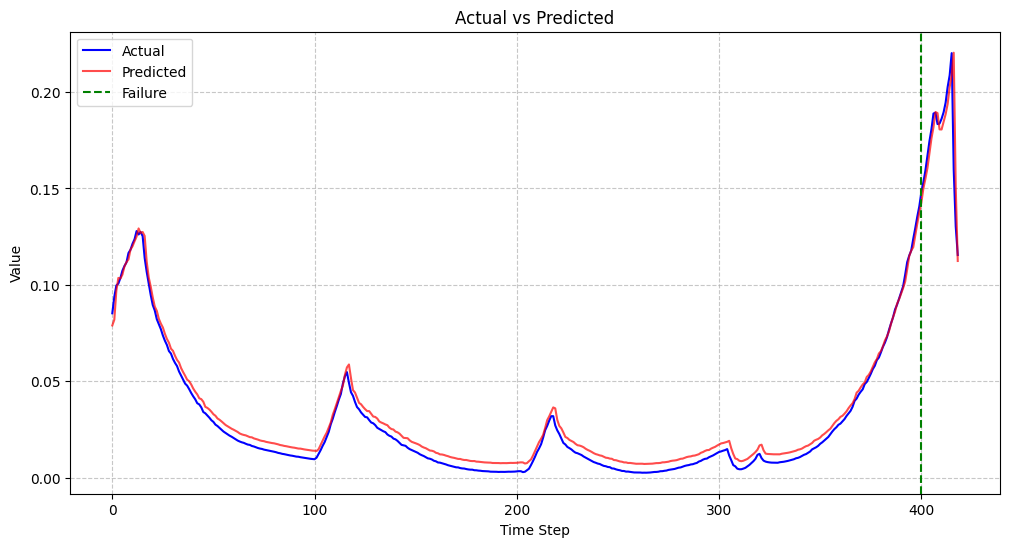

In [28]:
# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(last_values_target, label='Actual', color='blue')
plt.plot(last_values_pred, label='Predicted', color='red', alpha=0.7)

# Add a vertical line at the 400th position (failure point) -> Consider Voltage_measured below 3V as a failure.
plt.axvline(x=400, color='green', linestyle='--', linewidth=1.5, label='Failure')

# Set graph title and axis labels
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Display the graph
plt.show()
